In [1]:
using CSV
using DataFrames
using Random
using Plots
using JuMP, Gurobi
using Mosek
using MosekTools
const GRB_ENV = Gurobi.Env()

Academic license - for non-commercial use only - expires 2021-07-08


Gurobi.Env(Ptr{Nothing} @0x00007f97f8bd3e00, false, 0)

In [2]:
df = CSV.read("data/LA_2020_08_01.csv", DataFrame, header = false)
print("Map loaded")

Map loaded

In [3]:
function generate_stations(map, n_stations)
    n, m = size(map)
    x = randperm(n)[1:n_stations]
    y = randperm(m)[1:n_stations]
    return [x,y]
end

generate_stations (generic function with 1 method)

In [82]:
function generate_times(stations, map, prep_time, speed, cell_size)
    """
    stations: coordinates of fire stations
    map: the proba map
    prep_time: the time required to prepare trucks after an alert, in hours
    speed: fire truck speed, in km/h
    The Manhattan distance is used
    """
    l, w = size(map)
    s = size(stations[1],1)
    times = prep_time*ones(s,l,w)
    for k = 1:s
        for i = 1:l
            for j=1:w
                #Manhattan distance
                d = abs(stations[1][k]-i)+abs(stations[2][k]-j)
                times[k,i,j] += d*cell_size/speed
            end
        end
    end
    return times
end

generate_times (generic function with 2 methods)

## Visualize map and stations

In [4]:
x, y = generate_stations(df, 50)
stations = [x,y]

2-element Array{Array{Int64,1},1}:
 [45, 35, 72, 19, 61, 37, 77, 6, 17, 36  …  58, 76, 28, 9, 22, 62, 34, 31, 7, 82]
 [11, 64, 19, 3, 70, 27, 37, 52, 42, 28  …  55, 72, 9, 73, 33, 89, 60, 57, 62, 21]

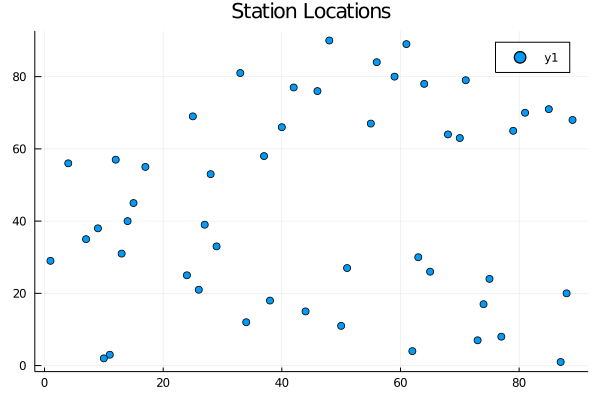

In [5]:
scatter(x, y, title = "Station Locations")

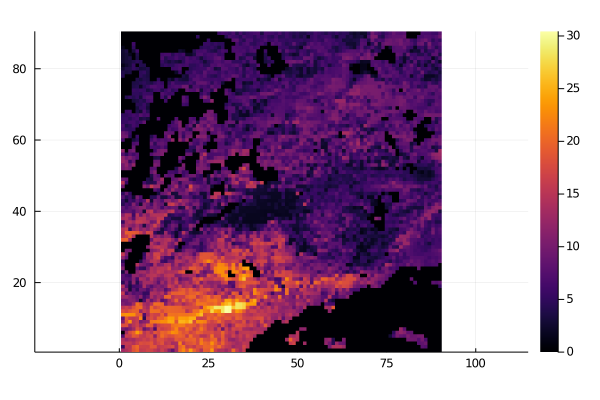

In [6]:
heatmap(Matrix(df), color=:inferno, aspect_ratio=1)

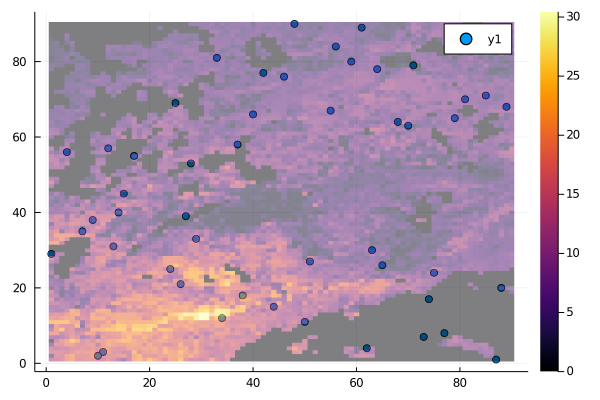

In [7]:
plt = scatter(x, y)
heatmap!(plt, Matrix(df), alpha=0.5)

In [6]:
x, y = generate_stations(df, 50)
stations = [x,y]
times = generate_times(stations, Matrix(df), 0.15, 60)

50×90×90 Array{Float64,3}:
[:, :, 1] =
 2.23333   2.21667   2.2       2.18333   …  1.45      1.46667   1.48333
 1.01667   1.0       0.983333  0.966667     2.36667   2.38333   2.4
 0.866667  0.85      0.833333  0.816667     1.61667   1.63333   1.65
 2.06667   2.05      2.03333   2.01667      0.616667  0.6       0.616667
 1.43333   1.41667   1.4       1.38333      2.51667   2.53333   2.55
 2.16667   2.15      2.13333   2.11667   …  1.01667   1.03333   1.05
 2.31667   2.3       2.28333   2.26667      1.6       1.61667   1.63333
 1.48333   1.46667   1.45      1.43333      0.966667  0.983333  1.0
 1.13333   1.11667   1.1       1.08333      2.28333   2.3       2.31667
 1.81667   1.8       1.78333   1.76667      1.5       1.51667   1.53333
 1.18333   1.16667   1.15      1.13333   …  1.5       1.51667   1.53333
 2.75      2.73333   2.71667   2.7          1.83333   1.85      1.86667
 1.86667   1.85      1.83333   1.81667      0.883333  0.9       0.916667
 ⋮                                      

In [7]:
trucks = 5*ones(50)
M = 5
a = 4
q = 0.2
x_c1 = 10
y_c1 = 10

10

***One Stage***
\begin{align}
        \min_{\boldsymbol{x}, \boldsymbol{z}, T} &\quad T \nonumber\\
        \text{s.t.} \quad & x_{s} \leq n_{s} \hspace{3.8cm}\forall \: s\in \mathcal{S} \\
        &\quad \quad  \text{(cannot send more than available trucks)} \nonumber\\
        & z_{s} \leq x_{s}\leq Mz_{s}\hspace{2.5cm} \forall \: s\in \mathcal{S}\\
        &\quad \quad \text{(must send trucks from chosen stations)}\nonumber\\
        & \sum_{s\in \mathcal{S}} x_{s} \geq ae^{q_{c_1}T}\\
        &\quad \quad \text{(number of trucks needed grows with time)} \nonumber\\
        & T \geq t(s, c_1)z_{s} \hspace{2.9cm}\forall \: s\in \mathcal{S}\\
        & \quad \quad \text{(T is time at which all trucks arrive)}\nonumber\\
        & z_{s}\in \{0,1\}\hspace{3.4cm}\forall \: s\in \mathcal{S}\\
        & x_{s}\in \mathbb{N}\hspace{4cm}\forall \: s\in \mathcal{S}
\end{align}

In [8]:
function one_stage(stations, times, trucks, M, a, q, x_c1, y_c1)
    model = Model(optimizer_with_attributes(Mosek.Optimizer, "QUIET" => false, "INTPNT_CO_TOL_DFEAS" => 1e-7))
    S = size(stations[1],1)
    
    #Variables
    @variable(model, x[1:S], Int)
    @variable(model, z[1:S], Bin)
    @variable(model, T >= 0)
    @variable(model, r >=0)
    
    #Constraints
    @constraint(model, [s in 1:S], z[s]<=x[s])
    @constraint(model, [s in 1:S], x[s]<=trucks[s]*z[s])
    @constraint(model, [q*T; 1; sum(x[s] for s in 1:S)/a] in MOI.ExponentialCone())   #sum x_s >= ae^(qT)
    @constraint(model, [s in 1:S], T >= times[s,x_c1,y_c1]*z[s])
    
    #Objective
    @objective(model, Min, T)
    optimize!(model)
    
    return objective_value(model), value.(model[:x]), value.(model[:r]), sum( value.(model[:x]))
end

one_stage (generic function with 1 method)

In [9]:
one_stage(stations, times, 5*ones(50), 5, 8, 0.1, 20, 20)

Problem
  Name                   :                 
  Objective sense        : min             
  Type                   : CONIC (conic optimization problem)
  Constraints            : 153             
  Cones                  : 1               
  Scalar variables       : 105             
  Matrix variables       : 0               
  Integer variables      : 100             

Optimizer started.
Mixed integer optimizer started.
Threads used: 12
Presolve started.
Presolve terminated. Time = 0.00
Presolved problem: 103 variables, 151 constraints, 351 non-zeros
Presolved problem: 50 general integer, 51 binary, 2 continuous
Clique table size: 0
BRANCHES RELAXS   ACT_NDS  DEPTH    BEST_INT_OBJ         BEST_RELAX_OBJ       REL_GAP(%)  TIME  
0        0        1        0        3.4420200000e+01     NA                   NA          0.0   
0        1        1        0        3.4420200000e+01     2.7385205908e-02     99.92       0.0   
0        1        1        0        2.4999997429e-01     2.73

(0.24999997429168924, [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 5.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.0, -0.0], 0.0, 10.0)

***Two Stages***
\begin{align}
        \min_{\boldsymbol{x}, \boldsymbol{z}, T} &\quad T_{c_1} + \gamma \sum_{c_2}p_{c_2} T_{c_2} \nonumber\\
        \text{s.t.} \quad & x^{c_1}_{s} \leq n_{s} \hspace{3.8cm}\forall \: s\in \mathcal{S} \\
        &\quad \quad  \text{(cannot send more than available trucks)} \nonumber\\
        & z^{c_1}_{s} \leq x^{c_1}_{s}\leq Mz^{c_1}_{s}\hspace{2.5cm} \forall \: s\in \mathcal{S}\\
        &\quad \quad \text{(must send trucks from chosen stations)}\nonumber\\
        & \sum_{s\in \mathcal{S}} x^{c_1}_{s} \geq ae^{q_{c_1}T}\\
        &\quad \quad \text{(number of trucks needed grows with time)} \nonumber\\
        & T \geq t(s, c_1)z^{c_1}_{s} \hspace{2.9cm}\forall \: s\in \mathcal{S}\\
        & \quad \quad \text{(T is time at which all trucks arrive)}\nonumber\\
        & z^{c_1}_{s}\in \{0,1\}\hspace{3.4cm}\forall \: s\in \mathcal{S}\\
        & x^{c_1}_{s}\in \mathbb{N}\hspace{4cm}\forall \: s\in \mathcal{S}\\
        & x^{c_2}_{s} \leq n_{s} - x^{c_1}_s \hspace{2.2cm}\forall c_2, \:\forall \: s\in \mathcal{S} \\
        &\quad \quad  \text{(cannot send more than available trucks)} \nonumber\\
        & z^{c_2}_{s} \leq x^{c_2}_{s}\leq Mz^{c_2}_{s}\hspace{1.7cm}\forall c_2, \forall \: s\in \mathcal{S}\\
        &\quad \quad \text{(must send trucks from chosen stations)}\nonumber\\
        & \sum_{s\in \mathcal{S}} x^{c_2}_{s} \geq ae^{q_{c_2}T}\hspace{1.8cm}\forall c_2,\\
        &\quad \quad \text{(number of trucks needed grows with time)} \nonumber\\
        & T \geq t(s, c_2)z^{c_2}_{s} \hspace{2.2cm}\forall c_2,\forall \: s\in \mathcal{S}\\
        & \quad \quad \text{($T$ is time at which all trucks arrive)}\nonumber\\
        & z^{c_2}_{s}\in \{0,1\}\hspace{2.7cm}\forall c_2,\forall \: s\in \mathcal{S}\\
        & x^{c_2}_{s}\in \mathbb{N}\hspace{3.3cm}\forall c_2,\forall \: s\in \mathcal{S}
\end{align}

In [17]:
function two_stage(stations, times, trucks, M, a, q_1, x_c1, y_c1, max_x, max_y, q, 𝛾, p, timelimit)
    model = Model(optimizer_with_attributes(Mosek.Optimizer, "QUIET" => false, "INTPNT_CO_TOL_DFEAS" => 1e-7, "TimeLimit" => timelimit))
    S = size(stations[1],1)
    
    #Variables for first fire
    @variable(model, x_1[1:S], Int)
    @variable(model, z_1[1:S], Bin)
    @variable(model, T_1 >= 0)

    #Variables for second fire
    @variable(model, x_2[1:S, 1:max_x, 1:max_y], Int)
    @variable(model, z_2[1:S, 1:max_x, 1:max_y], Bin)
    @variable(model, T_2[1:max_x, 1:max_y] >= 0)
    
    #Constraints for first fire
    @constraint(model, [s in 1:S], x_1[s]<=trucks[s]*z_1[s])
    @constraint(model, [s in 1:S], z_1[s]<=x_1[s])
    @constraint(model, [q_1*T_1; 1; sum(x_1[s] for s in 1:S)/a] in MOI.ExponentialCone())
    @constraint(model, [s in 1:S], T_1 >= times[s,x_c1,y_c1]*z_1[s])
    
    #Constraints for second fire
    @constraint(model, [s in 1:S], x_2[s, :, :] .<= (trucks[s] - x_1[s]))
    @constraint(model, [s in 1:S], x_2[s, :, :] .<= M*z_2[s, :, :])
    @constraint(model, [s in 1:S], z_2[s, :, :] .<=x_2[s, :, :])
    
    for x in 1:max_x
        for y in 1:max_y
            @constraint(model, [q[x, y]*T_2[x, y]; 1; sum(x_2[s, x, y] for s in 1:S)/a] in MOI.ExponentialCone())
            @constraint(model, [s in 1:S], T_2[x, y] .>= times[s,x,y]*z_2[s, x, y])
        end
    end


    #Objective
    @objective(model, Min, T_1 + 𝛾 * sum(p .*T_2))
    
    optimize!(model)
    return objective_value(model), value.(model[:x_1]), sum( value.(model[:x_2]))
    
end

two_stage (generic function with 2 methods)

In [138]:
function two_stage_linear(stations, times, trucks, M, a, q_1, x_c1, y_c1, max_x, max_y, q, 𝛾, p)
    model = Model(optimizer_with_attributes(Mosek.Optimizer, "QUIET" => false, "INTPNT_CO_TOL_DFEAS" => 1e-7, "MSK_IPAR_MIO_CUT_SELECTION_LEVEL" => 1, "MSK_DPAR_MIO_MAX_TIME" => 60))
    S = size(stations[1],1)
    
    #Variables for first fire
    @variable(model, x_1[1:S], Int)
    @variable(model, z_1[1:S], Bin)
    @variable(model, T_1 >= 0)

    #Variables for second fire
    @variable(model, x_2[1:S, 1:max_x, 1:max_y], Int)
    @variable(model, z_2[1:S, 1:max_x, 1:max_y], Bin)
    @variable(model, T_2[1:max_x, 1:max_y] >= 0)
    
    #Constraints for first fire
    @constraint(model, [s in 1:S], x_1[s]<=trucks[s]*z_1[s])
    @constraint(model, [s in 1:S], z_1[s]<=x_1[s])
    @constraint(model, sum(x_1[s] for s in 1:S)>=10+a*q_1*T_1)
    #@constraint(model, [q_1*T_1; 1; sum(x_1[s] for s in 1:S)/a] in MOI.ExponentialCone())
    @constraint(model, [s in 1:S], T_1 >= times[s,x_c1,y_c1]*z_1[s])
    
    #Constraints for second fire
    @constraint(model, [s in 1:S], x_2[s, :, :] .<= (trucks[s] - x_1[s]))
    @constraint(model, [s in 1:S], x_2[s, :, :] .<= M*z_2[s, :, :])
    @constraint(model, [s in 1:S], z_2[s, :, :] .<=x_2[s, :, :])
    
    for x in 1:max_x
        for y in 1:max_y
            @constraint(model, sum(x_2[s, x, y] for s in 1:S) >= 10+a*q_1*T_2[x, y])
            @constraint(model, [s in 1:S], T_2[x, y] .>= times[s,x,y]*z_2[s, x, y])
        end
    end


    #Objective
    @objective(model, Min, T_1 + 𝛾 * sum(p .*T_2))
    
    optimize!(model)
    return objective_value(model), value.(model[:x_1]), sum( value.(model[:x_2]))
    
end

two_stage_linear (generic function with 1 method)

In [ ]:
max_x = 10
max_y = 10
sub_probabilities = (Matrix(df)[1:max_x, 1:max_y])/50
sub_trucks = 5*ones(50)
sub_times = times[:, 1:max_x, 1:max_y]
M = 5
a = 8
q_1 = 0.1
x_c1, y_c1 = 8, 8
q = 0.1*ones(max_x, max_y)
𝛾 = 0.5
timelimit = 20

In [165]:
#SHORT VERSION FOT STATIONS AS WELL
max_x = 50
max_y = 50
sub_probabilities = (Matrix(df)[1:max_x, 1:max_y])/50

#sub_times = times[:, 1:max_x, 1:max_y]
M = 8
a = 8
q_1 = 0.1
x_c1, y_c1 = 8, 8
q = 0.1*ones(max_x, max_y)
𝛾 = 0.5
timelimit = 20

x, y = generate_stations(sub_probabilities, 40)
stations = [x,y]
sub_times = generate_times(stations, sub_probabilities, 0.15, 60)
sub_trucks = 6*ones(size(stations[1],1))

40-element Array{Float64,1}:
 6.0
 6.0
 6.0
 6.0
 6.0
 6.0
 6.0
 6.0
 6.0
 6.0
 6.0
 6.0
 6.0
 ⋮
 6.0
 6.0
 6.0
 6.0
 6.0
 6.0
 6.0
 6.0
 6.0
 6.0
 6.0
 6.0

In [139]:
two_stage_linear(stations, sub_times, sub_trucks, M, a, q_1, x_c1, y_c1, max_x, max_y, q, 𝛾, sub_probabilities)

Problem
  Name                   :                 
  Objective sense        : min             
  Type                   : LO (linear optimization problem)
  Constraints            : 19810           
  Cones                  : 0               
  Scalar variables       : 10075           
  Matrix variables       : 0               
  Integer variables      : 9750            

Optimizer started.
Mixed integer optimizer started.
Threads used: 12
Presolve started.
Presolve terminated. Time = 0.31
Presolved problem: 10075 variables, 19810 constraints, 44170 non-zeros
Presolved problem: 4875 general integer, 4875 binary, 325 continuous
Clique table size: 0
BRANCHES RELAXS   ACT_NDS  DEPTH    BEST_INT_OBJ         BEST_RELAX_OBJ       REL_GAP(%)  TIME  
0        1        1        0        NA                   1.8759602421e+00     NA          0.6   
0        1        1        0        2.6491131635e+01     1.8759602421e+00     92.92       16.7  
Cut generation started.
0        1        1        

(26.491131635228793, [5.0, 0.0, 0.0, -0.0, 0.0, 5.0, -0.0, -0.0, -0.0, -0.0, -0.0, 1.0, 1.0, 0.0, -0.0], 3628.0)

In [ ]:
two_stage(stations, sub_times, sub_trucks, M, a, q_1, x_c1, y_c1, max_x, max_y, q, 𝛾, sub_probabilities)

Problem
  Name                   :                 
  Objective sense        : min             
  Type                   : CONIC (conic optimization problem)
  Constraints            : 20453           
  Cones                  : 101             
  Scalar variables       : 10504           
  Matrix variables       : 0               
  Integer variables      : 10100           

Optimizer started.
Mixed integer optimizer started.
Threads used: 12
Presolve started.
Presolve terminated. Time = 0.20
Presolved problem: 10403 variables, 20251 constraints, 45451 non-zeros
Presolved problem: 5050 general integer, 5151 binary, 202 continuous
Clique table size: 0
BRANCHES RELAXS   ACT_NDS  DEPTH    BEST_INT_OBJ         BEST_RELAX_OBJ       REL_GAP(%)  TIME  
0        1        1        0        NA                   5.9366570537e-01     NA          0.8   
0        1        1        0        4.4414293955e+01     5.9366570537e-01     98.66       36.3  
Cut generation started.
0        1        1      

In [157]:
function two_stage_linear_callback(stations, times, trucks, M, a, q_1, x_c1, y_c1, max_x, max_y, q, 𝛾, p)
    #model = Model(optimizer_with_attributes(Mosek.Optimizer, "QUIET" => false, "INTPNT_CO_TOL_DFEAS" => 1e-7, "MSK_IPAR_MIO_CUT_SELECTION_LEVEL" => 1, "MSK_DPAR_MIO_MAX_TIME" => 60))
    model = Model(() -> Gurobi.Optimizer(GRB_ENV))
    set_optimizer_attributes(model, "TimeLimit" => 800, "OutputFlag" => 1)
    S = size(stations[1],1)
    
    #Variables for first fire
    @variable(model, x_1[1:S], Int)
    @variable(model, z_1[1:S], Bin)
    @variable(model, T_1 >= 0)

    #Variables for second fire
    @variable(model, x_2[1:S, 1:max_x, 1:max_y], Int)
    @variable(model, z_2[1:S, 1:max_x, 1:max_y], Bin)
    @variable(model, T_2[1:max_x, 1:max_y] >= 0)
    
    #Constraints for first fire
    @constraint(model, [s in 1:S], x_1[s]<=trucks[s]*z_1[s])
    @constraint(model, [s in 1:S], z_1[s]<=x_1[s])
    @constraint(model, sum(x_1[s] for s in 1:S)>=10+a*q_1*T_1)
    #@constraint(model, [q_1*T_1; 1; sum(x_1[s] for s in 1:S)/a] in MOI.ExponentialCone())
    @constraint(model, [s in 1:S], T_1 >= times[s,x_c1,y_c1]*z_1[s])
    
    #Constraints for second fire
    #@constraint(model, [s in 1:S], x_2[s, :, :] .<= (trucks[s]))# - x_1[s]))
    @constraint(model, [s in 1:S], x_2[s, :, :] .<= M*z_2[s, :, :])
    @constraint(model, [s in 1:S], z_2[s, :, :] .<=x_2[s, :, :])
    
    for x in 1:max_x
        for y in 1:max_y
            @constraint(model, sum(x_2[s, x, y] for s in 1:S) >= 10+a*q_1*T_2[x, y])
            @constraint(model, [s in 1:S], T_2[x, y] .>= times[s,x,y]*z_2[s, x, y])
        end
    end


    #Objective
    @objective(model, Min, T_1 + 𝛾 * sum(p .*T_2)+sum(x_1))
    
    "Define the callback function"
    function check_availability(cb_data)
        status = callback_node_status(cb_data, model)
        if status == MOI.CALLBACK_NODE_STATUS_INTEGER
            # get value of current solution
            for s in 1:S
                x_1_val = callback_value(cb_data, x_1[s])
                #x_2_val = zeros(Int, max_x, max_y)
                for x in max_x
                    for y in max_y
                        #x_2_val[x,y] = callback_value(cb_data, x_2[s,x,y])
                        x_2_val = callback_value(cb_data, x_2[s,x,y])
                        if x_2_val <= trucks[s] - x_1_val
                            cut = @build_constraint(x_2[s, x, y] <= (trucks[s] - x_1[s]))
                            MOI.submit(model, MOI.LazyConstraint(cb_data), cut)
                        end
                    end
                end
            end
        end
    end
    # set callback function and attach to model
    MOI.set(model, MOI.LazyConstraintCallback(), check_availability)
    optimize!(model)
    return objective_value(model), value.(model[:x_1]), sum( value.(model[:x_2]))
    
end

two_stage_linear_callback (generic function with 1 method)

In [155]:
function two_stage_linear_gurobi(stations, times, trucks, M, a, q_1, x_c1, y_c1, max_x, max_y, q, 𝛾, p)
    #model = Model(optimizer_with_attributes(Mosek.Optimizer, "QUIET" => false, "INTPNT_CO_TOL_DFEAS" => 1e-7, "MSK_IPAR_MIO_CUT_SELECTION_LEVEL" => 1, "MSK_DPAR_MIO_MAX_TIME" => 60))
    model = Model(() -> Gurobi.Optimizer(GRB_ENV))
    set_optimizer_attributes(model, "TimeLimit" => 800, "OutputFlag" => 1)
    S = size(stations[1],1)
    
    #Variables for first fire
    @variable(model, x_1[1:S], Int)
    @variable(model, z_1[1:S], Bin)
    @variable(model, T_1 >= 0)

    #Variables for second fire
    @variable(model, x_2[1:S, 1:max_x, 1:max_y], Int)
    @variable(model, z_2[1:S, 1:max_x, 1:max_y], Bin)
    @variable(model, T_2[1:max_x, 1:max_y] >= 0)
    
    #Constraints for first fire
    @constraint(model, [s in 1:S], x_1[s]<=trucks[s]*z_1[s])
    @constraint(model, [s in 1:S], z_1[s]<=x_1[s])
    @constraint(model, sum(x_1[s] for s in 1:S)>=10+a*q_1*T_1)
    #@constraint(model, [q_1*T_1; 1; sum(x_1[s] for s in 1:S)/a] in MOI.ExponentialCone())
    @constraint(model, [s in 1:S], T_1 >= times[s,x_c1,y_c1]*z_1[s])
    
    #Constraints for second fire
    @constraint(model, [s in 1:S], x_2[s, :, :] .<= (trucks[s] - x_1[s]))
    @constraint(model, [s in 1:S], x_2[s, :, :] .<= M*z_2[s, :, :])
    @constraint(model, [s in 1:S], z_2[s, :, :] .<=x_2[s, :, :])
    
    for x in 1:max_x
        for y in 1:max_y
            @constraint(model, sum(x_2[s, x, y] for s in 1:S) >= 10+a*q_1*T_2[x, y])
            @constraint(model, [s in 1:S], T_2[x, y] .>= times[s,x,y]*z_2[s, x, y])
        end
    end


    #Objective
    @objective(model, Min, T_1 + 𝛾 * sum(p .*T_2)+sum(x_1)+sum(z_1))
    
    optimize!(model)
    return objective_value(model), value.(model[:x_1]), sum( value.(model[:x_2]))
    
end

two_stage_linear_gurobi (generic function with 1 method)

In [158]:
two_stage_linear_callback(stations, sub_times, sub_trucks, M, a, q_1, x_c1, y_c1, max_x, max_y, q, 𝛾, sub_probabilities)

Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (mac64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 1223251 rows, 818201 columns and 2843451 nonzeros
Model fingerprint: 0x7b37534c
Variable types: 8101 continuous, 810100 integer (405050 binary)
Coefficient statistics:
  Matrix range     [1e-01, 8e+00]
  Objective range  [1e-02, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+01, 1e+01]
Presolve time: 4.42s
Presolved: 1223251 rows, 818201 columns, 2843451 nonzeros
Variable types: 8101 continuous, 810100 integer (405050 binary)
Found heuristic solution: objective 1465.3635385

Deterministic concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Root barrier log...

Ordering time: 0.76s

Barrier statistics:
 AA' NZ     : 1.235e+07
 Factor NZ  : 1.358e+07 (roughly 1.0 GBytes of memory)
 Factor Ops : 3.789e+08 (less than 1 second per iteration)
 Threads    : 4

                  Ob

(202.97092551852836, [-0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0  …  -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 6.0, -0.0], 95248.0)

In [156]:
two_stage_linear_gurobi(stations, sub_times, sub_trucks, M, a, q_1, x_c1, y_c1, max_x, max_y, q, 𝛾, sub_probabilities)

Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (mac64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 1628251 rows, 818201 columns and 3653451 nonzeros
Model fingerprint: 0x2208af31
Variable types: 8101 continuous, 810100 integer (405050 binary)
Coefficient statistics:
  Matrix range     [1e-01, 8e+00]
  Objective range  [1e-02, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e+00, 1e+01]
Presolve removed 0 rows and 0 columns (presolve time = 5s) ...
Presolve removed 0 rows and 0 columns (presolve time = 10s) ...
Presolve time: 12.60s
Presolved: 1628251 rows, 818201 columns, 3653451 nonzeros
Variable types: 0 continuous, 818201 integer (405050 binary)
Found heuristic solution: objective 677.3003012
Found heuristic solution: objective 590.5659433
Found heuristic solution: objective 582.3465822

Deterministic concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Root barrier log..

(582.3465822446526, [-0.0, -0.0, 6.0, 6.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0  …  -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0], 96605.0)

In [ ]:

@constraint(model, T_2[:, :] .>= sum(times[s,:,:].*z_2[s, :, :] for s in 1:S))

In [163]:
function two_stage_linear_callback_average(stations, times, trucks, M, a, q_1, x_c1, y_c1, max_x, max_y, q, 𝛾, p)
    #model = Model(optimizer_with_attributes(Mosek.Optimizer, "QUIET" => false, "INTPNT_CO_TOL_DFEAS" => 1e-7, "MSK_IPAR_MIO_CUT_SELECTION_LEVEL" => 1, "MSK_DPAR_MIO_MAX_TIME" => 60))
    model = Model(() -> Gurobi.Optimizer(GRB_ENV))
    set_optimizer_attributes(model, "TimeLimit" => 60, "OutputFlag" => 1)
    S = size(stations[1],1)
    
    #Variables for first fire
    @variable(model, x_1[1:S], Int)
    @variable(model, z_1[1:S], Bin)
    @variable(model, T_1 >= 0)

    #Variables for second fire
    @variable(model, x_2[1:S, 1:max_x, 1:max_y], Int)
    @variable(model, z_2[1:S, 1:max_x, 1:max_y], Bin)
    @variable(model, T_2[1:max_x, 1:max_y] >= 0)
    
    #Constraints for first fire
    @constraint(model, [s in 1:S], x_1[s]<=trucks[s]*z_1[s])
    @constraint(model, [s in 1:S], z_1[s]<=x_1[s])
    @constraint(model, sum(x_1[s] for s in 1:S)>=10+a*q_1*T_1)
    #@constraint(model, [q_1*T_1; 1; sum(x_1[s] for s in 1:S)/a] in MOI.ExponentialCone())
    @constraint(model, T_1 >= sum(times[s,x_c1,y_c1]*z_1[s] for s in 1:S))
    
    #Constraints for second fire
    #@constraint(model, [s in 1:S], x_2[s, :, :] .<= (trucks[s]))# - x_1[s]))
    @constraint(model, [s in 1:S], x_2[s, :, :] .<= M*z_2[s, :, :])
    @constraint(model, [s in 1:S], z_2[s, :, :] .<=x_2[s, :, :])
    
    for x in 1:max_x
        for y in 1:max_y
            @constraint(model, sum(x_2[s, x, y] for s in 1:S) >= 10+a*q_1*T_2[x, y])
            @constraint(model, T_2[:, :] .>= sum(times[s,:,:].*z_2[s, :, :] for s in 1:S))
        end
    end


    #Objective
    @objective(model, Min, T_1 + 𝛾 * sum(p .*T_2)+sum(x_1))
    
    "Define the callback function"
    function check_availability(cb_data)
        status = callback_node_status(cb_data, model)
        if status == MOI.CALLBACK_NODE_STATUS_INTEGER
            # get value of current solution
            for s in 1:S
                x_1_val = callback_value(cb_data, x_1[s])
                #x_2_val = zeros(Int, max_x, max_y)
                for x in max_x
                    for y in max_y
                        #x_2_val[x,y] = callback_value(cb_data, x_2[s,x,y])
                        x_2_val = callback_value(cb_data, x_2[s,x,y])
                        if x_2_val <= trucks[s] - x_1_val
                            cut = @build_constraint(x_2[s, x, y] <= (trucks[s] - x_1[s]))
                            MOI.submit(model, MOI.LazyConstraint(cb_data), cut)
                        end
                    end
                end
            end
        end
    end
    # set callback function and attach to model
    MOI.set(model, MOI.LazyConstraintCallback(), check_availability)
    optimize!(model)
    return objective_value(model), value.(model[:x_1]), sum( value.(model[:x_2]))
    
end

two_stage_linear_callback_average (generic function with 1 method)

In [166]:
two_stage_linear_callback_average(stations, sub_times, sub_trucks, M, a, q_1, x_c1, y_c1, max_x, max_y, q, 𝛾, sub_probabilities)

Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (mac64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 6452582 rows, 202581 columns and 256752742 nonzeros
Model fingerprint: 0x6752f0f5
Variable types: 2501 continuous, 200080 integer (100040 binary)
Coefficient statistics:
  Matrix range     [1e-01, 8e+00]
  Objective range  [1e-02, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+01, 1e+01]
Presolve removed 0 rows and 0 columns (presolve time = 88s) ...
Presolve time: 87.86s

Explored 0 nodes (0 simplex iterations) in 195.15 seconds
Thread count was 1 (of 12 available processors)

Solution count 0

Time limit reached
Best objective -, best bound -, gap -

User-callback calls 40305, time in user-callback 0.37 sec


LoadError: [91mResult index of attribute MathOptInterface.ObjectiveValue(1) out of bounds. There are currently 0 solution(s) in the model.[39m